In [1]:
using POMDPs, POMDPGym, Crux, Distributions, BSON, GridInterpolations, LinearAlgebra
using BSON: @save
using StatsFuns
using Random
using PGFPlots

┌ Warning: You are using Matplotlib 3.3.4, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/smkatz/.julia/packages/Plots/1KWPG/src/backends/pyplot.jl:29


In [2]:
pushPGFPlotsPreamble("\\usepgfplotslibrary{fillbetween}");
pushPGFPlotsPreamble("\\definecolor{dimgray}{rgb}{0.41, 0.41, 0.41}");
pushPGFPlotsPreamble("\\definecolor{lightgray}{rgb}{0.83, 0.83, 0.83}");

In [3]:
include("../../src/multilevel_estimation.jl")
include("../../src/montecarlo.jl")
include("../../src/gaussian_process.jl")
include("../../src/bandit.jl")
include("../../src/kernel_bandit.jl")
include("../../src/learning_bandit.jl")
include("../../src/pspec_bandit.jl")
include("controller.jl")
include("setup.jl")

pendulum_problem (generic function with 1 method)

# Load in the Ground Truth

In [4]:
function pendulum_mc_model(nθ, nω, nsamps; σθ_max=0.3, σω_max=0.3)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return MonteCarloModel(grid, nsamps)
end

model_gt = BSON.load("results/ground_truth.bson")[:model]
# Fix for bug when ground truth was generated
model_gt.β = model_gt.nsamps .+ model_gt.β .- 1
problem_gt = pendulum_problem(101, 101, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt, model_gt)

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_gt_small = pendulum_mc_model(nθ, nω, 10000; σθ_max=σθ_max, σω_max=σω_max)

function fill_in_small(model_gt, model_gt_small)
    for ind in 1:length(model_gt_small.grid)
        x = ind2x(model_gt_small.grid, ind)
        ind_orig = interpolants(model_gt.grid, x)[1][1]
        model_gt_small.α[ind] = model_gt.α[ind_orig]
        model_gt_small.β[ind] = model_gt.β[ind_orig]
        model_gt_small.pfail[ind] = model_gt.pfail[ind_orig]
    end
end

fill_in_small(model_gt, model_gt_small)
problem_gt_small = pendulum_problem(nθ, nω, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt_small, model_gt_small)

# Load in the PSpec Runs

In [5]:
ss1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:set_sizes_kkb]
ss2 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run2.bson")[:set_sizes_kkb]
ss3 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run3.bson")[:set_sizes_kkb]
ss4 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run4.bson")[:set_sizes_kkb]
ss5 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run5.bson")[:set_sizes_kkb];

ss1k = [s[2] for s in ss1]
ss2k = [s[2] for s in ss2]
ss3k = [s[2] for s in ss3]
ss4k = [s[2] for s in ss4]
ss5k = [s[2] for s in ss5];

ss = hcat(ss1k, ss2k, ss3k, ss4k, ss5k)
μ_ss = mean(ss, dims=2)[:]
σ_ss = std(ss, dims=2)[:];

pred_hi = μ_ss .+ σ_ss
pred_lo = μ_ss .- σ_ss;

In [17]:
model1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:model_kkb]
model2 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run2.bson")[:model_kkb]
model3 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run3.bson")[:model_kkb]
model4 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run4.bson")[:model_kkb]
model5 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run5.bson")[:model_kkb];

In [21]:
function get_rates(model)
    is_safe = falses(length(model.grid))
    for i = 1:length(model.grid)
        conf_ind = findfirst(cumsum(model.θdists[i, :]) .> 0.95)
        pfail_ind = findfirst(model.θs .>= 0.1)
        is_safe[i] = conf_ind ≤ pfail_ind
    end

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

models = [model1, model2, model3, model4, model5]

FPs_s = zeros(5)
FNs_s = zeros(5)
for (i, model) in enumerate(models)
    FNs_s[i], FPs_s[i] = get_rates(model)
end

In [22]:
FPs_s, FNs_s

([0.0, 0.0, 0.0, 0.0, 1.0], [2.0, 1.0, 1.0, 1.0, 1.0])

# Bandit Baseline

In [13]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

function get_rates(model, δ)
    test_stats = [quantile(Beta(α, β), δ) for (α, β) in zip(model.α, model.β)]
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

ss_b = []
FPs_b = zeros(5)
FNs_b = zeros(5)
for i = 1:5
    model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
    dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold)
    set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 50000)
    push!(ss_b, set_sizes_b)
    FNs_b[i], FPs_b[i] = get_rates(model_b, 0.95)
end

0.0%┣                                          ┫ 0/50.0k [00:00<-41:-40, -0s/it]
0.0%┣                                        ┫ 1/50.0k [00:00<Inf:Inf, InfGs/it]
0.1%┣                                          ┫ 62/50.0k [00:00<01:35, 527it/s]
0.3%┣                                         ┫ 129/50.0k [00:00<01:05, 770it/s]
0.4%┣▏                                        ┫ 188/50.0k [00:00<00:58, 864it/s]
0.5%┣▏                                        ┫ 247/50.0k [00:00<00:54, 921it/s]
0.6%┣▎                                        ┫ 302/50.0k [00:00<00:55, 907it/s]
0.8%┣▎                                        ┫ 377/50.0k [00:00<00:50, 983it/s]
0.9%┣▍                                       ┫ 447/50.0k [00:00<00:48, 1.0kit/s]
1.0%┣▍                                       ┫ 497/50.0k [00:00<00:48, 1.0kit/s]
1.1%┣▍                                        ┫ 528/50.0k [00:01<00:50, 986it/s]
1.2%┣▌                                        ┫ 580/50.0k [00:01<00:50, 991it/s]
1.3%┣▌                      

In [14]:
FPs_b, FNs_b

([0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 5.0, 2.0, 0.0, 7.0])

In [11]:
ss_b = hcat(ss_b...)
μ_ssb = mean(ss_b, dims=2)[:]
σ_ssb = std(ss_b, dims=2)[:]

pred_hib = μ_ssb .+ σ_ssb
pred_lob = μ_ssb .- σ_ssb;

# Random Baseline

In [48]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

function get_rates(model, δ)
    test_stats = [quantile(Beta(α, β), δ) for (α, β) in zip(model.α, model.β)]
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

ss_r = []
FPs_r = zeros(5)
FNs_r = zeros(5)
for i = 1:5
    model_r = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
    set_sizes_r = run_estimation!(model_r, problem, random_acquisition, 100000)
    push!(ss_r, set_sizes_r)
    FNs_r[i], FPs_r[i] = get_rates(model_r, 0.95)
end

0.0%┣                                      ┫ 0/100.0k [00:00<-1:-23:-20, -0s/it]
0.0%┣                                       ┫ 1/100.0k [00:00<Inf:Inf, InfGs/it]
0.1%┣                                         ┫ 81/100.0k [00:00<02:06, 790it/s]
0.2%┣                                       ┫ 164/100.0k [00:00<01:33, 1.1kit/s]
0.2%┣                                       ┫ 246/100.0k [00:00<01:22, 1.2kit/s]
0.3%┣▏                                      ┫ 322/100.0k [00:00<01:19, 1.3kit/s]
0.4%┣▏                                      ┫ 402/100.0k [00:00<01:15, 1.3kit/s]
0.5%┣▏                                      ┫ 476/100.0k [00:00<01:14, 1.3kit/s]
0.5%┣▏                                      ┫ 549/100.0k [00:00<01:13, 1.4kit/s]
0.6%┣▎                                      ┫ 622/100.0k [00:00<01:13, 1.4kit/s]
0.7%┣▎                                      ┫ 691/100.0k [00:01<01:13, 1.4kit/s]
0.8%┣▎                                      ┫ 765/100.0k [00:01<01:12, 1.4kit/s]
0.8%┣▎                      

In [49]:
FPs_r, FNs_r

([0.0, 0.0, 0.0, 0.0, 0.0], [11.0, 12.0, 12.0, 12.0, 8.0])

In [51]:
mean(FNs_r), std(FNs_r) / sqrt(5)

(11.0, 0.7745966692414833)

In [52]:
ss_r = hcat(ss_r...)
μ_ssr = mean(ss_r, dims=2)[:]
σ_ssr = std(ss_r, dims=2)[:]

pred_hir = μ_ssr .+ σ_ssr
pred_lor = μ_ssr .- σ_ssr;

# GP 1

In [28]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_gp_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, nsamps=500, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    # Set up the mean and kernel functions
    m(x) = zeros(length(x)) #0.5 * ones(length(x))
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    # Solve for variance based on coefficient of variation
    cv = √((1 - 0.1) / (0.1 * nsamps))
    ν = (0.1 * cv)^2

    return GaussianProcessModel(grid, nsamps, m, k, ν)
end

function get_rates(model, δ)
    all_X = [X for X in model.grid]
    all_inds = collect(1:length(model.grid))

    μ, σ² = predict(model, model.X, model.X_inds, model.y, all_X, all_inds, model.K)

    β = quantile(Normal(), δ)
    test_stats = μ .+ β .* sqrt.(σ²)
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

nsamps_tot = 44000
nsamps_indiv = 100

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

MILE_acquisition(model) = MILE_acquisition(model, problem.pfail_threshold, problem.conf_threshold)

ss_gp1 = []
FNs_gp1 = zeros(5)
FPs_gp1 = zeros(5)
for i = 1:5
    model_gp1 = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
    set_sizes_gp1 = run_estimation!(model_gp1, problem, MILE_acquisition, nsamps_tot)
    push!(ss_gp1, set_sizes_gp1)
    FNs_gp1[i], FPs_gp1[i] = get_rates(model_gp1, 0.95)
end

0.0%┣                                             ┫ 0/440 [00:00<00:-22, -0s/it]
0.2%┣                                          ┫ 1/440 [00:00<Inf:Inf, InfGs/it]
0.5%┣▏                                              ┫ 2/440 [00:00<01:14, 6it/s]
0.7%┣▎                                              ┫ 3/440 [00:00<01:01, 7it/s]
0.9%┣▍                                              ┫ 4/440 [00:00<01:06, 7it/s]
1.1%┣▌                                              ┫ 5/440 [00:01<01:00, 7it/s]
1.4%┣▋                                              ┫ 6/440 [00:01<00:55, 8it/s]
1.6%┣▊                                              ┫ 7/440 [00:01<00:53, 8it/s]
1.8%┣▉                                              ┫ 8/440 [00:01<00:52, 8it/s]
2.0%┣█                                              ┫ 9/440 [00:01<00:51, 8it/s]
2.3%┣█                                             ┫ 10/440 [00:01<00:50, 9it/s]
2.5%┣█▏                                            ┫ 11/440 [00:01<00:49, 9it/s]
2.7%┣█▎                     

In [29]:
FPs_gp1, FNs_gp1

([0.0, 0.0, 0.0, 0.0, 0.0], [6.0, 7.0, 6.0, 10.0, 7.0])

In [30]:
ss_gp1 = hcat(ss_gp1...)
μ_ssgp1 = mean(ss_gp1, dims=2)[:]
σ_ssgp1 = std(ss_gp1, dims=2)[:]

pred_higp1 = μ_ssgp1 .+ σ_ssgp1
pred_logp1 = μ_ssgp1 .- σ_ssgp1;

# GP 2

In [31]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_gp_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, nsamps=500, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    # Set up the mean and kernel functions
    m(x) = zeros(length(x)) #0.5 * ones(length(x))
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    # Solve for variance based on coefficient of variation
    cv = √((1 - 0.1) / (0.1 * nsamps))
    ν = (0.1 * cv)^2

    return GaussianProcessModel(grid, nsamps, m, k, ν)
end

function get_rates(model, δ)
    all_X = [X for X in model.grid]
    all_inds = collect(1:length(model.grid))

    μ, σ² = predict(model, model.X, model.X_inds, model.y, all_X, all_inds, model.K)

    β = quantile(Normal(), δ)
    test_stats = μ .+ β .* sqrt.(σ²)
    is_safe = test_stats .< 0.1

    FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
    FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)

    return length(FN_inds), length(FP_inds)
end

nsamps_tot = 100000
nsamps_indiv = 5000

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

MILE_acquisition(model) = MILE_acquisition(model, problem.pfail_threshold, problem.conf_threshold)

ss_gp2 = []
FNs_gp2 = zeros(5)
FPs_gp2 = zeros(5)
for i = 1:5
    model_gp2 = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
    set_sizes_gp2 = run_estimation!(model_gp2, problem, MILE_acquisition, nsamps_tot)
    push!(ss_gp2, set_sizes_gp2)
    FNs_gp2[i], FPs_gp2[i] = get_rates(model_gp2, 0.95)
end

0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:03<Inf:Inf, InfGs/it]
10.0%┣████▊                                          ┫ 2/20 [00:06<01:53, 6s/it]
15.0%┣███████                                        ┫ 3/20 [00:10<01:28, 5s/it]
20.0%┣█████████▍                                     ┫ 4/20 [00:14<01:17, 5s/it]
25.0%┣███████████▊                                   ┫ 5/20 [00:19<01:10, 5s/it]
30.0%┣██████████████                                 ┫ 6/20 [00:23<01:04, 5s/it]
35.0%┣████████████████▌                              ┫ 7/20 [00:27<00:58, 4s/it]
40.0%┣██████████████████▉                            ┫ 8/20 [00:31<00:53, 4s/it]
45.0%┣█████████████████████▏                         ┫ 9/20 [00:35<00:48, 4s/it]
50.0%┣███████████████████████                       ┫ 10/20 [00:39<00:44, 4s/it]
55.0%┣█████████████████████████▎                    ┫ 11/20 [00:43<00:39, 4s/it]
60.0%┣██████████████████████

In [32]:
FPs_gp2, FNs_gp2

([0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0])

In [33]:
ss_gp2 = hcat(ss_gp2...)
μ_ssgp2 = mean(ss_gp2, dims=2)[:]
σ_ssgp2 = std(ss_gp2, dims=2)[:]

pred_higp2 = μ_ssgp2 .+ σ_ssgp2
pred_logp2 = μ_ssgp2 .- σ_ssgp2;

# False Positive/Negative Plot

In [34]:
FP_s_mean = mean(FPs_s)
FP_s_std = std(FPs_s)
FN_s_mean = mean(FNs_s)
FN_s_std = std(FNs_s)

FP_b_mean = mean(FPs_b)
FP_b_std = std(FPs_b)
FN_b_mean = mean(FNs_b)
FN_b_std = std(FNs_b)

FP_r_mean = mean(FPs_r)
FP_r_std = std(FPs_r)
FN_r_mean = mean(FNs_r)
FN_r_std = std(FNs_r)

FP_gp1_mean = mean(FPs_gp1)
FP_gp1_std = std(FPs_gp1)
FN_gp1_mean = mean(FNs_gp1)
FN_gp1_std = std(FNs_gp1)

FP_gp2_mean = mean(FPs_gp2)
FP_gp2_std = std(FPs_gp2)
FN_gp2_mean = mean(FNs_gp2)
FN_gp2_std = std(FNs_gp2)

0.0

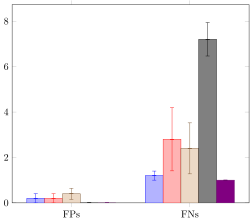

In [44]:
ax = Axis(Plots.BarChart(["FPs", "FNs"], [FP_s_mean, FN_s_mean],
    errorBars=ErrorBars(y=[FP_s_std / sqrt(5), FN_s_std / sqrt(5)])),
    style="enlarge x limits={0.5}")
push!(ax, Plots.BarChart(["FPs", "FNs"], [FP_b_mean, FN_b_mean],
    errorBars=ErrorBars(y=[FP_b_std / sqrt(5), FN_b_std / sqrt(5)])))
push!(ax, Plots.BarChart(["FPs", "FNs"], [FP_r_mean, FN_r_mean],
    errorBars=ErrorBars(y=[FP_r_std / sqrt(5), FN_r_std / sqrt(5)])))
push!(ax, Plots.BarChart(["FPs", "FNs"], [FP_gp1_mean, FN_gp1_mean],
    errorBars=ErrorBars(y=[FP_gp1_std / sqrt(5), FN_gp1_std / sqrt(5)])))
push!(ax, Plots.BarChart(["FPs", "FNs"], [FP_gp2_mean, FN_gp2_mean],
    errorBars=ErrorBars(y=[FP_gp2_std / sqrt(5), FN_gp2_std / sqrt(5)])))
ax.width="10cm"
PGFPlots.save("pend_error_rates.tex", ax, include_preamble=false)
ax

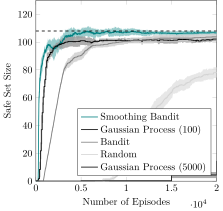

In [56]:
nsamps_indiv_1 = 100
nsamps_indiv_2 = 5000

xmax = 20000
step = 1

ax = Axis(Plots.Linear(collect(0:step:xmax), μ_ss[1:step:xmax+1], mark="none",
    style="thick, teal", legendentry="Smoothing Bandit"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hi[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lo[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40, forget plot] fill between[of=A and B];"))

end_ind = convert(Int64, floor(xmax / nsamps_indiv_1) + 1)
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), pred_higp1[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), pred_logp1[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), μ_ssgp1[1:end_ind], mark="none",
    style="thick, black, const plot", legendentry="Gaussian Process (100)"))

push!(ax, Plots.Linear(collect(0:step:xmax), pred_hib[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lob[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[gray!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssb[1:step:xmax+1], mark="none", style="thick, gray",
    legendentry="Bandit"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssr[1:step:xmax+1], mark="none", style="thick, lightgray",
    legendentry="Random"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hir[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lor[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[lightgray!70, opacity=0.8, forget plot] fill between[of=A and B];"))

end_ind = convert(Int64, floor(xmax / nsamps_indiv_2) + 1)
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), pred_higp2[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), pred_logp2[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), μ_ssgp2[1:end_ind], mark="none",
    style="thick, black, const plot", legendentry="Gaussian Process (5000)"))

push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="thick, black, dashed"))

ax.xmin = 0.0
ax.xmax = xmax
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax.legendPos = "south east"
ax.width = "8cm"
ax.height = "8cm"
PGFPlots.save("pend_results_big.tex", ax, include_preamble=false)
ax